In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import gc
from tqdm.autonotebook import tqdm

from sklearn.metrics import accuracy_score,f1_score

import sklearn

import torch
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-a35c0700917c>:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv("/content/I-Sarcasm_train_.csv")
test_data = pd.read_csv("/content/I-Sarcasm_test_.csv")

In [ ]:
questions = pd.read_csv("/content/I-Sarcasm_train_.csv",usecols=["tweet", "sarcasm_label"])
# questions.columns = ["tweet", "sarcasm_label"]


In [ ]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "tweet")

questions.to_csv("clean_data.csv")

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["tweet"].apply(str).apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,tweet,sarcasm_label,tokens
0,0,it's been a while since i visited my grandpare...,not_sarcastic,"[it, s, been, a, while, since, i, visited, my,..."
1,1,well done monty mark that up as your first ev...,not_sarcastic,"[well, done, monty, mark, that, up, as, your, ..."
2,2,since this is fantasy can it be any individua...,not_sarcastic,"[since, this, is, fantasy, can, it, be, any, i..."
3,3,really? i don't think you know what you are ta...,not_sarcastic,"[really, i, don, t, think, you, know, what, yo..."
4,4,missed toughenough tonight? no worries just ...,sarcastic,"[missed, toughenough, tonight, no, worries, ju..."


In [ ]:
clean_questions = pd.read_csv("clean_data.csv")


In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

50696 words total, with a vocabulary size of 10432
Max sentence length is 41


In [ ]:
train_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,NaN
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,NaN
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,NaN
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,NaN
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [ ]:
test_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,NaN
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,NaN
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,NaN
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [ ]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train_data.drop("tweet_id",inplace=True,axis=1)

In [ ]:
train_tweets=train_data['tweet'].tolist()
test_tweets=test_data['tweet'].tolist()


In [ ]:
train_data.describe().T

,count,unique,top,freq
tweet,3577,3523,LOL...Walker is talking about education...the ...,3
sarcasm_label,3577,2,not_sarcastic,2297
sarcasm_type,1279,7,sarcasm,880


In [ ]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [ ]:
train_data.isna().sum()

tweet_id            0
tweet               0
sarcasm_label       0
sarcasm_type     2298
dtype: int64

In [ ]:
train_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,NaN
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,NaN
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,NaN
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,NaN
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [ ]:
train_data["sarcasm_type"].fillna("No sarcasm",inplace=True)


,text,labels
1401,"""The Hague: Warlord Offers a Defense"" by MARLI...",0
1618,@AdrianMaxwell62 @TheTodayShow @Channel9 Why d...,1
3033,This is SO my #dog! #corgisofinstagram #corgin...,0
2664,"Wow, there are so many wonderful people on Cra...",1
748,Life sucks because some people make it difficu...,1


In [ ]:
train_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,No sarcasm
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,No sarcasm
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,No sarcasm
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,No sarcasm
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [ ]:
test_data.isna().sum()

tweet_id           0
tweet              0
sarcasm_label      0
sarcasm_type     640
dtype: int64

In [ ]:
test_data["sarcasm_type"].fillna("No sarcasm",inplace=True)
test_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,No sarcasm
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,No sarcasm
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,No sarcasm
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [ ]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train_data.drop("tweet_id",inplace=True,axis=1)

In [ ]:
test_data.drop("tweet_id",inplace=True,axis=1)

In [ ]:
train_data.sarcasm_type.replace("#news #live #breakingnews Premarket: Blood-letting eases for global stocks, but China smashed again","No sarcasm",inplace=True)

In [ ]:
train_data.sarcasm_label.value_counts()

not_sarcastic    2297
sarcastic        1280
Name: sarcasm_label, dtype: int64

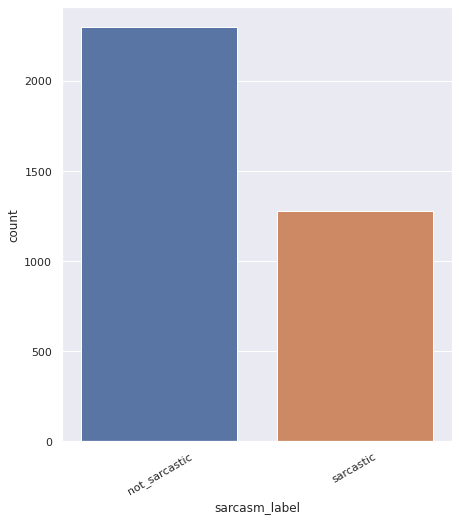

In [ ]:
sns.countplot(train_data.sarcasm_label)
sns.set(rc={'figure.figsize':(7,8)})
plt.xticks(rotation=30);

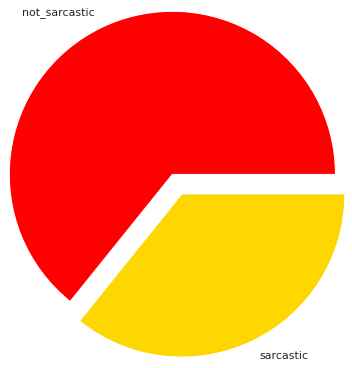

In [ ]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1]
train_data.sarcasm_label.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["red", "gold", "green",'blue','purple','red']);


In [ ]:
train_data.sarcasm_type.value_counts()

No sarcasm             2299
sarcasm                 880
irony                   261
overstatement            47
rhetorical question      43
satire                   39
understatement            8
Name: sarcasm_type, dtype: int64

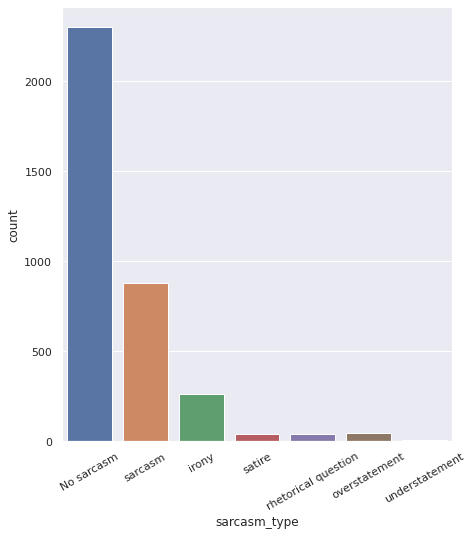

In [ ]:
sns.countplot(train_data.sarcasm_type)
sns.color_palette("mako", as_cmap=True)

plt.xticks(rotation=30);

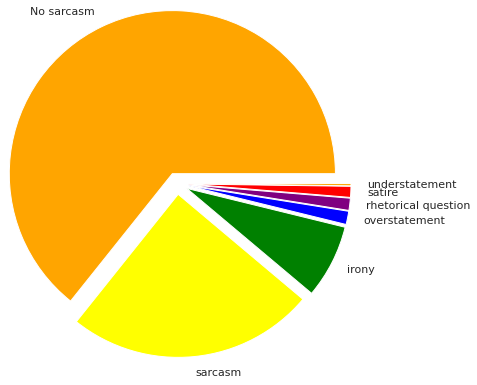

In [ ]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1]
sns.set_theme(style="whitegrid")
train_data.sarcasm_type.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["orange", "yellow", "green",'blue','purple','red']);


In [ ]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [ ]:
tqdm.pandas() 

train_data['cleaned_text']= train_data['tweet'].progress_apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweet'].progress_apply((lambda x: clean(x)))

  0%|          | 0/3577 [00:00<?, ?it/s]

  0%|          | 0/907 [00:00<?, ?it/s]

In [ ]:
train_data.drop("sarcasm_type",inplace=True,axis=1)
train_data.head()

,tweet,sarcasm_label,cleaned_text
0,It's been a while since I visited my grandpare...,not_sarcastic,since visited grandparentswait
1,Well done Monty. Mark that up as your first ev...,not_sarcastic,well done monty mark first ever 100 honest acc...
2,@davesnyder since this is fantasy can it be an...,not_sarcastic,since fantasy individual time alive today
3,Really? I don't think you know what you are ta...,not_sarcastic,really think know talking please provide evide...
4,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,missed toughenough tonight worries watch episo...


In [ ]:
train_data.head()

,tweet,sarcasm_label,cleaned_text
0,It's been a while since I visited my grandpare...,not_sarcastic,since visited grandparentswait
1,Well done Monty. Mark that up as your first ev...,not_sarcastic,well done monty mark first ever 100 honest acc...
2,@davesnyder since this is fantasy can it be an...,not_sarcastic,since fantasy individual time alive today
3,Really? I don't think you know what you are ta...,not_sarcastic,really think know talking please provide evide...
4,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,missed toughenough tonight worries watch episo...


In [ ]:
train_data['tweet'] = train_data['tweet'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [ ]:

train_data["tweet"] = train_data["tweet"].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]','',text,re.I|re.A))
train_data.head(10)

,tweet,sarcasm_label,cleaned_text
0,Its been a while since I visited my grandparen...,not_sarcastic,since visited grandparentswait
1,Well done Monty Mark that up as your first eve...,not_sarcastic,well done monty mark first ever 100 honest acc...
2,davesnyder since this is fantasy can it be any...,not_sarcastic,since fantasy individual time alive today
3,Really I dont think you know what you are talk...,not_sarcastic,really think know talking please provide evide...
4,Missed ToughEnough tonight No worries Just wat...,sarcastic,missed toughenough tonight worries watch episo...
5,Life has a funny way of helping you out when Y...,sarcastic,life funny way helping think everythings gone ...
6,Open road live life peace notraffic,not_sarcastic,open road ðÿššðÿš˜ live life peace notraffic
7,An Ounce of MIND NUMBING TERROR Humor,not_sarcastic,ounce mind numbing terror humor
8,Great Waldo Of China by LTCartoons parody humo...,not_sarcastic,great waldo china parody humor funny whereswal...
9,You know its going to be a great day of work w...,sarcastic,know going great day work counting minutes cas...


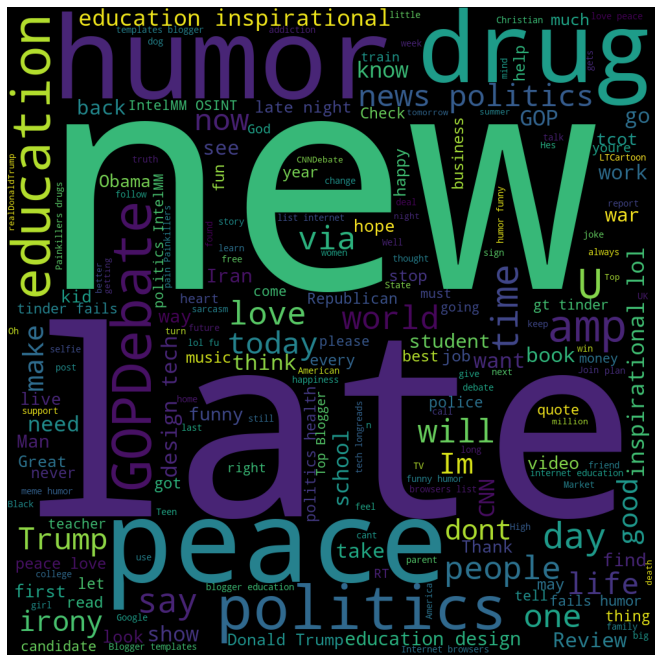

In [ ]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train_data.tweet[train_data['sarcasm_label']=='not_sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(background_color='black',stopwords=stopwords,
                         min_font_size=5,width=1000, height=1000).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

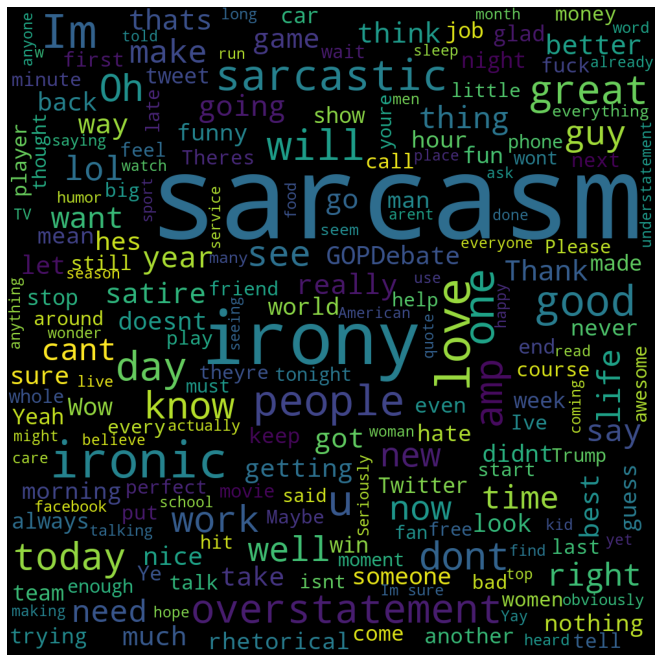

In [ ]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train_data.tweet[train_data['sarcasm_label']=='sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(
                         background_color='black',stopwords=stopwords,
                         min_font_size=5,width=1000, height=1000).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

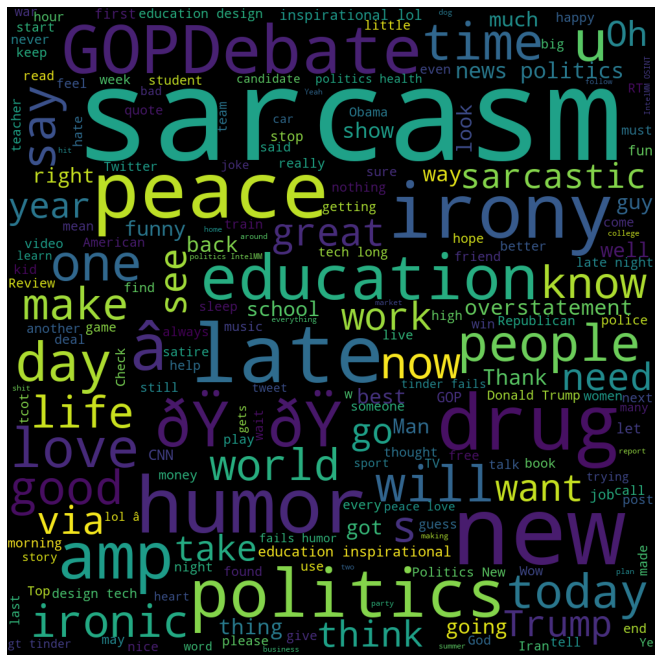

In [ ]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train_data.tweet:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(width=1000,height=1000,
                         background_color='black',stopwords=stopwords,
                         min_font_size=5).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [ ]:
# Concatenate all tweets into one string
text = " ".join(train_data['tweet'].tolist())

# Generate the wordcloud
wordcloud = WordCloud().generate(text)

# Access the words_ attribute to get the frequencies of the words
word_frequencies = wordcloud.words_

# Sort the dictionary by frequency to get the most frequent words
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words
print("Most frequent words:")
for word, frequency in sorted_words[:10]:
    print(f"{word}: {frequency}")

Most frequent words:
sarcasm: 1.0
new: 0.4722550177095632
late: 0.3282172373081464
peace: 0.3022432113341204
humor: 0.3010625737898465
drug: 0.28689492325855964
irony: 0.27863046044864226
GOPDebate: 0.21369539551357733
politics: 0.2101534828807556
education: 0.18299881936245574


In [ ]:
sarcastic_text = " ".join(train_data[train_data['sarcasm_label'] == 'sarcastic']['tweet'].tolist())
non_sarcastic_text = " ".join(train_data[train_data['sarcasm_label'] == 'not_sarcastic']['tweet'].tolist())

sarcastic_wordcloud = WordCloud().generate(sarcastic_text)
non_sarcastic_wordcloud = WordCloud().generate(non_sarcastic_text)

sarcastic_word_frequencies = sarcastic_wordcloud.words_
non_sarcastic_word_frequencies = non_sarcastic_wordcloud.words_

sorted_sarcastic_words = sorted(sarcastic_word_frequencies.items(), key=lambda x: x[1], reverse=True)
sorted_non_sarcastic_words = sorted(non_sarcastic_word_frequencies.items(), key=lambda x: x[1], reverse=True)

print("Most frequent sarcastic words:")
for word, frequency in sorted_sarcastic_words[:10]:
    print(f"{word}: {frequency}")

print("\nMost frequent non-sarcastic words:")
for word, frequency in sorted_non_sarcastic_words[:10]:
    print(f"{word}: {frequency}")


Most frequent sarcastic words:
sarcasm: 1.0
irony: 0.24330900243309003
ironic: 0.08759124087591241
Im: 0.07907542579075426
love: 0.07907542579075426
sarcastic: 0.06326034063260341
one: 0.06326034063260341
people: 0.06204379562043796
good: 0.06204379562043796
u: 0.06204379562043796

Most frequent non-sarcastic words:
new: 1.0
late: 0.6862244897959183
peace: 0.6581632653061225
humor: 0.6505102040816326
drug: 0.6071428571428571
politics: 0.5178571428571429
GOPDebate: 0.42091836734693877
education: 0.4030612244897959
amp: 0.2780612244897959
U: 0.22704081632653061


In [ ]:
train_data

,tweet,sarcasm_label,cleaned_text
0,It's been a while since I visited my grandpare...,not_sarcastic,since visited grandparentswait
1,Well done Monty. Mark that up as your first ev...,not_sarcastic,well done monty mark first ever 100 honest acc...
2,@davesnyder since this is fantasy can it be an...,not_sarcastic,since fantasy individual time alive today
3,Really? I don't think you know what you are ta...,not_sarcastic,really think know talking please provide evide...
4,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,missed toughenough tonight worries watch episo...
...,...,...,...
3572,"Hey Christine Nixon, people like @johannhari10...",not_sarcastic,hey christine nixon people like cover every si...
3573,#Erythropoietin #Drugs market to reach $11.9 b...,not_sarcastic,erythropoietin drugs market reach 119 billion ...
3574,Apple's first Android app wants you to stop us...,sarcastic,apples first android app wants stop using andr...
3575,Hurry! Ending soon! Follow b4 16.09.15 4chance...,not_sarcastic,hurry ending soon follow b4 160915 4chance2win...


In [ ]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'not_sarcastic':0,
        'sarcastic':1
    }
    return class_dict[t_class]

In [ ]:
train_data["target"] = train_data['sarcasm_label'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['sarcasm_label'].apply(lambda x: encode_target(x))

In [ ]:
train = train_data[['tweet','target']]
train.columns = ['text','labels']

test = test_data[['tweet','target']]
test.columns = ['text','labels']

In [ ]:
train.head()

,text,labels
1401,"""The Hague: Warlord Offers a Defense"" by MARLI...",0
1618,@AdrianMaxwell62 @TheTodayShow @Channel9 Why d...,1
3033,This is SO my #dog! #corgisofinstagram #corgin...,0
2664,"Wow, there are so many wonderful people on Cra...",1
748,Life sucks because some people make it difficu...,1


In [ ]:
test.head()

,text,labels
60,#DRUGS #India : India has destroyed only 30% o...,0
328,69 days alcohol free days.. #Irony #CorruptMin...,1
849,Android design http://t.co/5gbLcCLKGy #android...,0
99,Top 17 breakfasts that are too cool for #WordP...,1
556,Stoke and Liverpool fans must be really lookin...,1


In [ ]:
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     # args=train_args
# )

In [ ]:
!pip install transformers
import transformers

model_type = 'distilbert'
model_name = 'distilbert-base-cased'
model = transformers.pipeline("text-classification", model=model_name, tokenizer=model_name)


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score


In [ ]:
model_type = 'distilbert'
model_name = 'distilbert-base-uncased'
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 128,
               'gradient_accumulation_steps': 2,
#                'do_lower_case': True,
               'learning_rate': 1e-5,
               'overwrite_output_dir': True,
               'manual_seed': seed,
               'num_train_epochs': 4}


In [ ]:
model = ClassificationModel(model_type, model_name,num_labels=4,args=model_args,use_cuda=False) 
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     args=train_args
# ) 
#args=model_args


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [ ]:
model.train_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

(56, 0.8786859512329102)

In [ ]:
result_train, model_outputs_train, wrong_predictions_train = model.eval_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/448 [00:00<?, ?it/s]

In [ ]:
print("TRAIN SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result_train['acc']*100))
print("%s: %.5f" % ('Final Loss', result_train['eval_loss']))

TRAIN SET EVALUATION:
Accuracy: 77.86%
Final Loss: 0.62304


In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(test,acc=accuracy_score)

  0%|          | 0/907 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/114 [00:00<?, ?it/s]

In [ ]:
print("TEST SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result['acc']*100))
print("%s: %.5f" % ('Final Loss', result['eval_loss']))

TEST SET EVALUATION:
Accuracy: 81.26%
Final Loss: 0.55997


In [ ]:
test.shape

(907, 2)

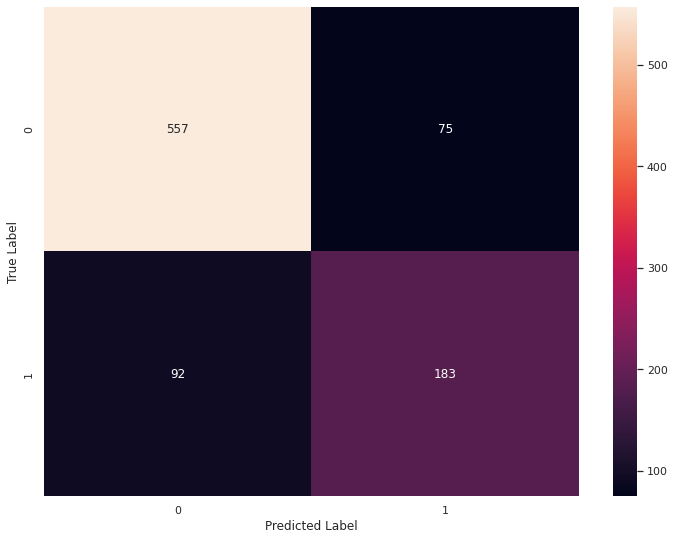

In [ ]:
from sklearn.metrics import confusion_matrix



confusion_matrix = confusion_matrix(test.labels, model_outputs)
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.gcf().set_size_inches(12,9)

plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

In [ ]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

In [ ]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

In [ ]:
print("NAIVE BAYES CLASSIFIER")
print("========================================================")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Naive Bayes on Hash Vectors
# accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
# print("-> Hash Vectors Accuracy: ", round(accuracy,2)) 85 89

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 79.9425% 
-> WordLevel TF-IDF Accuracy: 78.4001%
